In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('/kaggle/input/llm-dataset/filtered_data_clean.csv')

In [4]:
data.head()

,text,label,clean_text
0,We should keep the Electoral College for a num...,0,keep electoral college number reasons usually ...
1,Limiting car usage can actually be effective b...,0,limiting car usage actually effective belief l...
2,"Dear Principal,\n\nAfter school or during scho...",0,dear principal school school activities like b...
3,"Many people think that aliens are real, but th...",0,many people think aliens real theyre many peop...
4,I think if a student has a C average he or she...,0,think student c average may able participate s...


In [5]:
texts = data['clean_text'].tolist()
labels = data['label'].tolist()

In [6]:
train_texts = texts[:50000] + texts[120001:120001+50000]
train_labels = labels[:50000] + labels[120001:120001+50000]

(array([50000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 50000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

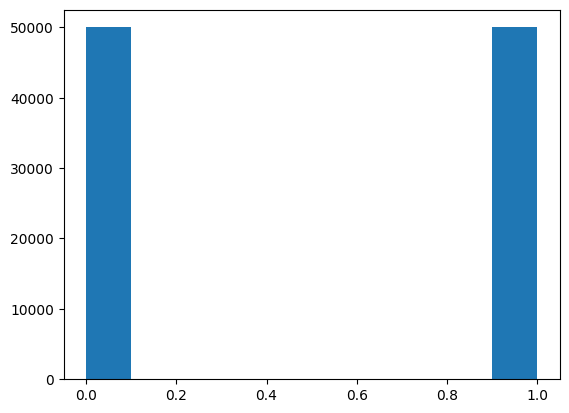

In [7]:
import matplotlib.pyplot as plt
plt.hist(train_labels)

In [8]:
from transformers import DistilBertTokenizerFast
import torch

In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained('/kaggle/input/tokenizer')

In [10]:
type(train_texts)

list

In [11]:
train_texts = [str(text) for text in train_texts]

In [12]:
enc = tokenizer(train_texts, truncation=True, padding=True)

In [ ]:
predictions = []

In [14]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
dataset = TextDataset(enc, train_labels)

In [16]:
batch_size = 32

In [17]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
count_0 = 0
count_1 = 0
for batch in loader:
    for label in batch["labels"]:
        if label.item()==1:
            count_1 += 1
        else :
            count_0 += 1
    break;
count_0, count_1

(16, 16)

In [19]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [22]:
learning_rate = 5e-5

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
lossi = []

In [25]:
from tqdm.autonotebook import tqdm

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
for epoch in range(3):
    loss_ = 0
    predictions = []
    true_labels =  []

    for batch in tqdm(loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        loss_ += loss.item()

        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    loss_ = loss_/len(loader)
    print(f"Epoch {epoch + 1} - Training Loss: {loss_:.4f}")

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch + 1} - Training Accuracy: {accuracy:.4f}")

    lossi.append(loss_)

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1 - Training Loss: 0.0380
Epoch 1 - Training Accuracy: 0.9870


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2 - Training Loss: 0.0097
Epoch 2 - Training Accuracy: 0.9973


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3 - Training Loss: 0.0056
Epoch 3 - Training Accuracy: 0.9983


In [28]:
model.to("cpu")

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [29]:
torch.save(model,'model_6.pt')

In [30]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
for epoch in range(3):
    loss_ = 0
    predictions = []
    true_labels =  []

    for batch in tqdm(loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        loss_ += loss.item()

        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
    loss_ = loss_/len(loader)
    print(f"Epoch {epoch + 1} - Training Loss: {loss_:.4f}")

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch + 1} - Training Accuracy: {accuracy:.4f}")

    lossi.append(loss_)

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1 - Training Loss: 0.0042
Epoch 1 - Training Accuracy: 0.9987


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2 - Training Loss: 0.0043
Epoch 2 - Training Accuracy: 0.9989


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3 - Training Loss: 0.0023
Epoch 3 - Training Accuracy: 0.9993


In [32]:
model.to("cpu")

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [33]:
torch.save(model,'model_distilbert.pt')
